# Measuring SNR of an Audio Sample

In order to quantify our demodulator, we need to measure the SNR of
baseband signals.

If we don't have a pristine copy of the baseband, we have to estimate
the noise by finding pure noise, one completely free of the signal,
either in the time domain or in the frequency domain to use as a base
for the noise estimate.

This post discusses one way to do this.

https://dsp.stackexchange.com/questions/35403/calculate-the-snr-of-wav-file

This is the formula that they suggest.

$ SNR=\frac{P(signal)+P(noise)-P(noise)}{P(noise)} $

But one cannot really just subtract noise from a signal.

For M17, the 4-FSK baseband is restricted to 3500Hz and below.  Here the spectrum
of a -121dBm signal from a vector signal generator into an RTL SDR running `rtl_fm`.

![M17 Baseband](m17-baseband-spectrum.png)

Beyond the roll-off, there is channel noise.  What we really want to measure
is the noise in the null after the roll-off.  And for that we can use a DFT. For
this we will use a sliding DFT implementation used elsewhere for data carrier
detection.

In [1]:
%pylab inline

import cmath
import numpy as np

class SlidingDFT(object):

    """Based on 'Understanding and Implementing the Sliding DFT'
    Eric Jacobsen, 2015-04-23
    https://www.dsprelated.com/showarticle/776.php
    """
    
    PI2 = cmath.pi * 2.0

    def __init__(self, frequency, sample_rate, N = 32):
        self.sample_rate = sample_rate
        self.frequency = frequency
        self.size = N
        self.samples = np.zeros(int(self.size), dtype=float);
        self.normalized_sample_rate = float(frequency) / float(sample_rate)
        self.coeff = cmath.exp(- 1j * self.PI2 * self.normalized_sample_rate)
        self.coeff2 = cmath.exp(- 1j * self.PI2 * self.normalized_sample_rate * 2)
        self.index = 0
        self.prev_result = 0j

    def __call__(self, sample):
        
        index = self.index
        self.index += 1
        if self.index == self.size:
            self.index = 0
        delta = (sample - self.samples[index])
        result = (self.prev_result + delta) * self.coeff
        self.prev_result = result * 0.9999999
        self.samples[index] = sample
        return result

Populating the interactive namespace from numpy and matplotlib


In [2]:
def plot_to_notebook(samples, sample_rate, legend = [], lines = ['-'], props = None):
    
    duration = len(samples) / sample_rate
    t = np.linspace(0, duration, len(samples), endpoint=True)
    plt.figure()
    plt.rcParams['figure.figsize'] = [12, 8]
    ax = plt.subplot(1, 1, 1)
    if props is not None: ax.set_prop_cycle(props)
    plt.xlabel('Time (sec)')
    plt.locator_params(axis='y', nbins=8)
    plt.grid()
    plt.xticks(np.arange(0, duration, 10.0/sample_rate), rotation=45)
    try:
        if len(samples[0]) > 1:
            lines = lines * len(samples[0])
            for i in range(len(samples[0])):
                plt.plot(t, [x[i] for i in samples], lines[i])
        else:
            plt.plot(t, samples, lines[0])
    except:
        plt.plot(t, samples, lines[0])

    plt.legend(legend)

We will define two DFTs with 500Hz resolution, one at 1500Hz, near the center
of the M17 baseband passband, and one at 3500Hz, near the null shown in the
spectrum plot above.

We are then going to measure a file

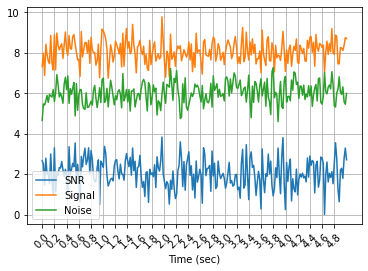

In [3]:
import scipy.io.wavfile

signal = SlidingDFT(1500, 48000, 96)
noise = SlidingDFT(3500, 48000, 96)

chunk_size = 960

sample_rate, baseband = scipy.io.wavfile.read('test-122dBm.wav')

baseband = baseband[96000:7*48000]

sig_x = np.zeros(len(baseband)//chunk_size)
noi_x = np.zeros(len(baseband)//chunk_size)
snr_x = np.zeros(len(baseband)//chunk_size)

for i in range(0, len(baseband) // chunk_size):
    idx = i * chunk_size
    sig_x[i] = np.abs(np.mean(np.abs([signal(x) for x in baseband[idx:idx + chunk_size]])))
    noi_x[i] = np.abs(np.mean(np.abs([noise(x) for x in baseband[idx:idx + chunk_size]])))
    snr_x[i] = 10 * np.log10(abs(0 if noi_x[i] == 0 else (sig_x[i]) / noi_x[i]))

plot_to_notebook(list(zip(snr_x, (10 * np.log10(sig_x)) - 45, (10 * np.log10(noi_x)) - 45)), 48000/960, ['SNR', 'Signal', 'Noise'])

Let's summarize this noisy graph into a simple SNR value in dB.

In [4]:
sig = np.mean(sig_x)
noi = np.mean(noi_x)
snr = 10 * np.log10((sig) / noi)

print(f'Signal = {sig:3.2f} - {10 * np.log10(sig):3.2f}dB, Noise = {noi:3.2f} - {10 * np.log10(noi):3.2f}dB, SNR = {snr:3.2f}dB')

Signal = 205307.29 - 53.12dB, Noise = 127375.00 - 51.05dB, SNR = 2.07dB


## SNR to Eb/N0

We now need to convert our SNR value to Eb/NO (energy per bit to noise power
spectral density ratio).  The formula for this is:

$ E_b/N_0 = {SNR}{\frac{B_{Hz}}{f_b}} $

Where $f_b$ is the information rate and $B_{Hz}$ is the channel bandwidth.

For M17, we have a $B_{Hz}$ of roughly 8900Hz.  The information rate, $ f_b $,
is a little more difficult.  The information rate of each of the frame types,
the link setup frame, the audio stream frame, the packet frame, and the LICH,
are all different.  We are going to focus on just the audio frame for now.

The audio frame use a punctured 1:2 convolutional code to acheive a rate 6:11.
at 9600 bits per second, that equates to an $ f_b $ of 5236.

In [5]:
print(f'Eb/N0 = {snr * (8900.0 / 5236.0):3.2f}')

Eb/N0 = 3.52
